In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from nb_002 import *

In [2]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'imagenet'

In [10]:
def dict_groupby(iterable, key=None):
    return {k:list(v) for k,v in itertools.groupby(sorted(iterable, key=key), key=key)}

def resolve_pipeline(tfms, **kwargs):
    tfms = listify(tfms)
    if len(tfms)==0: return noop
    grouped_tfms = dict_groupby(tfms, lambda o: o.__annotations__['return'])
    lighting_tfms,coord_tfms,affine_tfms,pixel_tfms,final_tfms = map(grouped_tfms.get, TfmType)
    lighting_tfm = apply_lighting_tfms(lighting_tfms)
    affine_tfm = compose_affine_tfms(affine_tfms, funcs=coord_tfms, **kwargs)
    pixel_tfm = compose_tfms(pixel_tfms)
    final_tfm = compose_tfms(final_tfms)
    return lambda x,**k: final_tfm(affine_tfm(lighting_tfm(pixel_tfm(x)), **k))

In [11]:
class TransformedFilesDataset(Dataset):
    def __init__(self, folder, sz, tfms=None, classes=None):
        self.fns, self.y = [], []
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        self.sz, self.tfms = sz, tfms

    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        x = pil2tensor(x)
        if self.tfms is not None:
            x = resolve_pipeline(self.tfms, size=self.sz)(x) 
        return x,self.y[i]

In [12]:
sz, bs = 224, 64
stats = (np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225]))
train_tfms =  [flip_lr_tfm(p=0.5),
              zoom_tfm(scale=(0.9,1.1),p=0.75),
              rotate_tfm(degrees=(-10,10.),p=0.75),
              crop_tfm(size=sz)]

In [13]:
train_ds = TransformedFilesDataset(PATH/'train', sz, train_tfms)

In [14]:
train_dl = get_dataloader(train_ds, bs, shuffle=False, stats=stats)

Numpy grid sample implementation

In [56]:
def select_with_black_padding(input, x, y):
    y1, x1 = np.clip(y, 0, input.shape[2]-1), np.clip(x, 0, input.shape[3]-1)
    result = input[:,:,y1.astype(int),x1.astype(int)]
    mask = (y < 0) + (y >= input.shape[2]) + (x < 0) + (x >= input.shape[3])
    mask = np.clip(mask, 0, 1)
    result[:,:,mask.astype(bool)] = 0
    return result

In [126]:
def select_with_border_padding(input, x, y):
    y1, x1 = np.clip(y, 0, input.shape[2]-1), np.clip(x, 0, input.shape[3]-1)
    return input[:,:,y1.astype(int),x1.astype(int)]

In [50]:
def select_with_reflective_padding(input, x, y):
    x[x < 0] = -x[x < 0]
    y[y < 0] = -y[y < 0]
    x[x >= input.shape[3]] = 2 * input.shape[3] - 1 - x[x >= input.shape[3]]
    y[y >= input.shape[2]] = 2 * input.shape[2] - 1 - y[y >= input.shape[2]]
    return input[:,:,y.astype(int),x.astype(int)]

In [51]:
def select_with_padding(input,x,y,padding):
    pad_functions = {'zeros':select_with_black_padding, 
                     'border':select_with_border_padding, 
                     'reflect':select_with_reflective_padding}
    return pad_functions[padding](input,x,y)

In [113]:
def nearest_interpol(input, coords, padding):
    return select_with_padding(input, np.round(coords[:,:,0]), np.round(coords[:,:,1]), padding)

In [116]:
def bilinear_interpol(input, coords, padding):
    x0, y0 = np.floor(coords[:,:,0]), np.floor(coords[:,:,1])
    delta_x, delta_y = coords[:,:,0] - x0, coords[:,:,1]-y0
    vals_00 = select_with_padding(input, x0, y0, padding)
    vals_10 = select_with_padding(input, x0, y0+1, padding)
    vals_01 = select_with_padding(input, x0+1, y0, padding)
    vals_11 = select_with_padding(input, x0+1, y0+1, padding)
    remapped = (vals_00 * (1-delta_y)* (1-delta_x) +  vals_10 * delta_y * (1-delta_x) +
                vals_01 * (1-delta_y) * delta_x    +  vals_11 * delta_y * delta_x)
    return remapped

In [142]:
def grid_sample(input, coords, mode, padding):
    interpol_functions = {'nearest':nearest_interpol, 
                          'bilinear':bilinear_interpol}
    _,_,h,w = input.shape
    coords = (coords[0] + 1) * np.array([h/2,w/2])[None]
    return interpol_functions[mode](input, coords, padding)

In [143]:
x = PIL.Image.open(train_ds.fns[0])
x = pil2tensor(x)
x = x.numpy()

In [144]:
x.shape

(3, 250, 250)

In [145]:
theta = math.pi * 30 / 180
matrix = torch.tensor([[math.cos(theta), -math.sin(theta), 0],
                       [math.sin(theta), math.cos(theta), 0]])

In [161]:
coords = F.affine_grid(matrix[None], torch.Size([1,3,250,250]))

In [147]:
coords.size()

torch.Size([1, 250, 250, 2])

Numpy

In [156]:
%timeit y = grid_sample(x[None], coords.numpy(), 'bilinear', 'border')

23 ms ± 436 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [148]:
%timeit y = grid_sample(x[None], coords.numpy(), 'bilinear', 'zeros')

25.8 ms ± 345 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


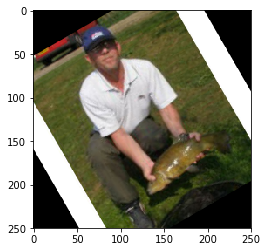

In [137]:
plt.imshow(y[0].transpose(1,2,0))

Grid sample CPU

In [162]:
x1 = PIL.Image.open(train_ds.fns[0])
x1 = pil2tensor(x1)

In [165]:
%timeit y = F.grid_sample(x1[None], coords, padding_mode='zeros')

3.9 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Grid sample GPU

In [159]:
x1 = x1.cuda()
coords = coords.cuda()

In [160]:
%timeit y = F.grid_sample(x1[None], coords)

71.6 µs ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
